<a href="https://colab.research.google.com/github/lilyzhizhou/ML-Final-Project/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVM for predicting prediabetes

### Import data and process

In [1]:
# Import necessary libraries/modules
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.svm import SVC  # Support Vector Classifier (SVM) for classification
from sklearn.metrics import classification_report, accuracy_score  # For evaluating the classifier
import plotly.express as px  # For data visualization with Plotly
import numpy as np  # For numerical operations
from sklearn.pipeline import Pipeline  # For creating a machine learning pipeline
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold  # For hyperparameter tuning and cross-validation
import pandas as pd  # For working with data in a DataFrame format
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load data
datapd = pd.read_csv('datapd.csv')

# Drop Patient_ID
datapd.drop('Patient_ID', axis = 1, inplace = True)
datapd.drop('Unnamed: 0', axis = 1, inplace = True)

datapd.head()

,predm,Age_at_Exam,BMI,Total_Cholesterol,Depression,HTN,OA,COPD,corstrd_bin,htnmed_bin,Sex
0,1,63,30.9,NaN,0,1,0,1,0,1,1
1,1,66,23.6,3.54,1,1,1,0,0,1,1
2,0,68,34.3,5.55,1,1,1,0,0,1,0
3,1,73,28.5,3.78,1,1,0,1,1,1,0
4,0,53,33.4,5.38,0,1,1,0,1,1,0


In [3]:
#check dataset shape, variable types, and missing values
print(datapd.shape)
print(datapd.dtypes)
print(datapd.isnull().sum())
#there are 152 missing values for TG

print((datapd['Total_Cholesterol'].isnull().sum() / len(datapd)) * 100)
#this is around 2% of data

(6414, 11)
predm                  int64
Age_at_Exam            int64
BMI                  float64
Total_Cholesterol    float64
Depression             int64
HTN                    int64
OA                     int64
COPD                   int64
corstrd_bin            int64
htnmed_bin             int64
Sex                    int64
dtype: object
predm                  0
Age_at_Exam            0
BMI                    0
Total_Cholesterol    152
Depression             0
HTN                    0
OA                     0
COPD                   0
corstrd_bin            0
htnmed_bin             0
Sex                    0
dtype: int64
2.369816027439975


In [4]:
# 1. Split the data into features and target variable
# specify x and y
Xdf = datapd.drop('predm', axis=1)
ydf = datapd['predm']
# convert to numpy array for SVM
X = np.stack(Xdf.values)
y = ydf.values

# 2. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Split the training set into a smaller training set and a validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# 4. Imputation of missing values
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_valid = imputer.fit_transform(X_valid)
X_test = imputer.fit_transform(X_test)

# 5. Normalization of the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.fit_transform(X_test)

In [5]:
# view outcome distribution in all sets

train_distribution = np.mean(y_train == 1) * 100
print("Training set")
print(train_distribution)

test_distribution = np.mean(y_test == 1) * 100
print("\nTesting set")
print(test_distribution)

valid_distribution = np.mean(y_valid == 1) * 100
print("\nValidation set")
print(valid_distribution)

#each set has around 40% prediabetes, which is balanced

Training set
41.29417879417879

Testing set
40.76383476227591

Validation set
39.28293063133281


## SVM

In [6]:
# Create and train an initial SVM classifier with linear kernel
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear')

In [7]:
# Make predictions on the test set
y_pred_train = svm_classifier.predict(X_train)
y_pred_test = svm_classifier.predict(X_test)

# Evaluate the model
print('----------- Train --------------')
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("\nClassification Report:\n", classification_report(y_train, y_pred_train))

print('----------- Test --------------')
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))

# pretty low initial recall and f1

----------- Train --------------
Accuracy: 0.6385135135135135

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.74      0.71      2259
           1       0.57      0.49      0.53      1589

    accuracy                           0.64      3848
   macro avg       0.62      0.62      0.62      3848
weighted avg       0.63      0.64      0.63      3848

----------- Test --------------
Accuracy: 0.6453624318004677

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.74      0.71       760
           1       0.57      0.50      0.54       523

    accuracy                           0.65      1283
   macro avg       0.63      0.62      0.62      1283
weighted avg       0.64      0.65      0.64      1283



In [8]:
#view parameters of initial SVM model
model_params = svm_classifier.get_params()
for param, value in model_params.items():
    print(f"{param}: {value}")

C: 1.0
break_ties: False
cache_size: 200
class_weight: None
coef0: 0.0
decision_function_shape: ovr
degree: 3
gamma: scale
kernel: linear
max_iter: -1
probability: False
random_state: None
shrinking: True
tol: 0.001
verbose: False


### Hyperparameter tuning

In [9]:
### parameters
# c: balances misclassification and maximizing the margin (high c = small margin, less misclass)
# kernal: linear, polynomial, radial
  # degree for polynomial
  # gamma for polynomial and radial
    # higher gamma = more fitted to training data

# Create an instance of the Support Vector Classifier (SVC) with class weight balancing
svm = SVC(class_weight='balanced')

# Define a dictionary of hyperparameter values to search over
param_dist = {
    'class_weight': [None, 'balanced'],
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'sigmoid', {'poly': {'degree': 2}}, {'poly': {'degree': 3}}, 'rbf'],
    'gamma': [0.01, 1, 10, 'scale', 'auto']
}
# parameter options include parameters of first model, plus additional options

# Use Kfold (stratified not used because outcome class is balanced)

# Create a StratifiedKFold cross-validation object with 3 folds
kf = KFold(n_splits=3)

# Perform a grid search with cross-validation to find the best hyperparameters
random_search = GridSearchCV(
    svm,  # SVM classifier instance
    param_grid=param_dist,  # Hyperparameter grid to search
    cv=kf,  # Cross-validation
    scoring='f1_micro'  # Scoring metric ('f1_micro' for balanced evaluation)
)

In [10]:
# Perform a grid search with cross-validation to find the best hyperparameters for an SVM model.
random_search.fit(X_train, y_train)

# Create a DataFrame to store the results of the grid search.
results = pd.DataFrame(random_search.cv_results_)

# Filter and select the best-performing hyperparameter set based on the 'rank_test_score'.
# The hyperparameter set with the lowest rank_test_score is considered the best.
best_results = results[results['rank_test_score'] == 1]

# runtime: 3 min

In [11]:
# view best parameters found by gridsearch
pd.set_option('display.max_colwidth', None)
print(best_results)
pd.reset_option

     mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
119       0.277604      0.004884         0.145986        0.002583       1   

    param_class_weight param_gamma param_kernel  \
119               None       scale          rbf   

                                                                params  \
119  {'C': 1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}   

     split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
119            0.64848           0.643024           0.632605          0.64137   

     std_test_score  rank_test_score  
119        0.006586                1  


### Train, test, and validate SVM model

In [12]:
# Set the hyperparameters of the SVM model to the best parameters found during the random search.
model = svm.set_params(**random_search.best_params_)

# Train the SVM model using the training data.
model = model.fit(X_train, y_train)

In [13]:
# Use the trained model to predict the training, validation, and test data.
y_pred_train = model.predict(X_train)
y_pred_valid = model.predict(X_valid)
y_pred_test = model.predict(X_test)

# Print performance metrics for the training data.
print('----------- Train --------------')
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("\nClassification Report:\n", classification_report(y_train, y_pred_train))

# Print performance metrics for the validation data.
print('----------- Validation --------------')
print("Accuracy:", accuracy_score(y_valid, y_pred_valid))
print("\nClassification Report:\n", classification_report(y_valid, y_pred_valid))

# Print performance metrics for the test data.
print('----------- Test --------------')
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))

# still not good

----------- Train --------------
Accuracy: 0.6837318087318087

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.80      0.75      2259
           1       0.65      0.52      0.57      1589

    accuracy                           0.68      3848
   macro avg       0.67      0.66      0.66      3848
weighted avg       0.68      0.68      0.68      3848

----------- Validation --------------
Accuracy: 0.6438035853468433

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.77      0.72       779
           1       0.56      0.46      0.50       504

    accuracy                           0.64      1283
   macro avg       0.62      0.61      0.61      1283
weighted avg       0.63      0.64      0.64      1283

----------- Test --------------
Accuracy: 0.6609508963367108

Classification Report:
               precision    recall  f1-score   support

           0       0.69   

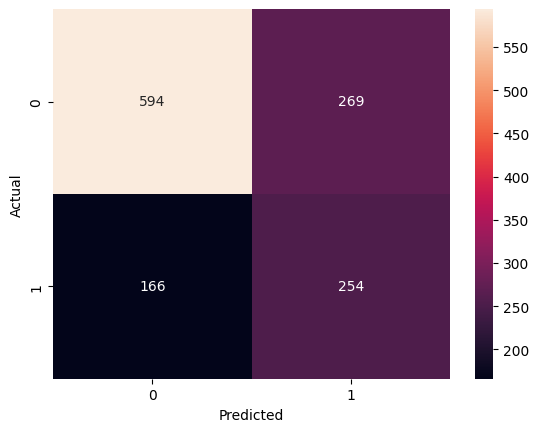

In [22]:
#confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_pred_test, y_test)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

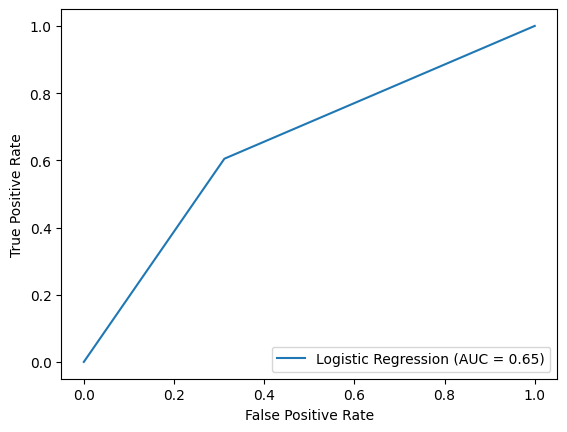

In [23]:
#ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_pred_test, y_test)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')
display.plot()